# The Mathematics of Drilling Intercepts

- toc: true
- branch: master
- badges: true
- comments: true

## Introduction


Drilling intercepts are a prominent feature of junior mining news releases. They are closely monitored by the mining investment community, and a particularly good intercept can raise the prospects for a project. 

As an example, consider this November 10 2020 release from Freegold Ventures:

> *Freegold Intercepts 3.78 g/t Au Over 119 Metres Including 131.5 g/t Over 3 Metres Within 573 Metres of 1.21 g/t Au at Golden Summit*

The market responded with a 3% boost in the share price the next trading day, so clearly this was regarded as a positive signal for the company's prospects. [(This is typical: capital markets tend to treat any news of this sort as good news.)](https://doi.org/10.1177%2F0312896212473401)

The implications for the economic, geological, and engineering variables surrounding the project are much less clear. *Is this a good geological result? Is it a good engineering result?* Intercepts are *highlights*: incomplete data, collected and released selectively, so is it even possible to make an informed judgement using these numbers?

To complicate things even further, the selectively reported drilling intercepts are usually released in a rather complex manner, which can make it difficult to distinguish between truly good numbers and deceptively good results.  Drilling intercepts are discussed at great length in other sources (here and here and here) but we'll take a mathematical perspective and develop a model that describes nested intercept configurations of arbitrary complexity.
 
We'll take Great Bear Resources for an extended example. Great Bear Resources is a Canadian junior mining company whose stock gained substantially on announcement of very high grade intercepts at their Dixie project in Ontario. At time of writing, GBR is trading at a $886 million CAD market cap (which is not very bearish at all!) 

<!-- TradingView Widget BEGIN -->
<div class="tradingview-widget-container">
  <div class="tradingview-widget-container__widget"></div>
  <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/TSXV-GBR/" rel="noopener" target="_blank"><span class="blue-text">GBR Price Today</span></a> by TradingView</div>
  <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-single-quote.js" async>
  {
  "symbol": "TSXV:GBR",
  "width": "100%",
  "colorTheme": "light",
  "isTransparent": false,
  "locale": "en"
}
  </script>
</div>
<!-- TradingView Widget END -->


In [1]:
#hide

from google.colab import drive
drive.mount('/content/drive')


!pip install anytree

from anytree import Node, RenderTree

from anytree import Node, RenderTree, AsciiStyle, LevelOrderIter



Mounted at /content/drive



Here we open up the spreadsheet of drilling results (available on their website), and then filter on `Drill Hole` to consider a single hole:

In [53]:
import pandas as pd

intercepts = pd.read_excel('drive/My Drive/Projects/posts/data/Great_Bear/lp_drill_hole_composites_all.xlsx')
intercepts['Record'] = intercepts.index

dh = intercepts[intercepts['Drill Hole'] == 'BR-022']

dh

,Drill Hole,Unnamed: 1,From (m),To (m),Width (m),Gold (g/t),Record
95,BR-022,including,110.0,116.10,6.10,2.62,95
96,BR-022,and including,111.4,113.10,1.70,7.92,96
97,BR-022,and,274.0,299.00,25.00,0.19,97
98,BR-022,and,432.9,439.00,6.10,4.05,98
99,BR-022,including,432.9,435.70,2.80,8.18,99
100,BR-022,and,445.0,452.00,7.00,0.41,100
101,BR-022,and,461.6,512.00,50.40,1.78,101
102,BR-022,including,471.0,512.00,41.00,2.09,102
103,BR-022,and including,471.0,478.00,7.00,2.37,103
104,BR-022,and including,490.0,491.00,1.00,8.15,104


This is how intercepts are typically presented: a table with a `From` field describing where they started measuring, a `To` field describing where they stopped, and a `Grade` field (called `Gold` here) that tells us how enriched that interval is with the valuable stuff. `From` and `To` are typically measured downhole from the drill collar. 

It's easy to establish a basic understanding of how these tables are read, and many experienced mining investors immediately recognize these grades as very high. The rest of us might need to rely on statistics, since we don't have the benefit of many years' experience with drilling results. 

Of course it is first necessary to determine the true assay values for each separate interval from top to bottom. Unfortunately, each row is not independent - some of the intercepts are contained in others, and the subinterval gold is INCLUDED in the parent interval calculation! So we can't just use the `Gold (g/t)` field directly, since intercepts are reported with these "highlights", or higher grade sections within the longer interval. 

Sometimes this convention is used unethically to suggest larger intervals of enrichment than truly exist. This is called "grade smearing" and the method of residual grade calculation applied here will detect any such attempt to disguise poor results. 

At first it may seem like the correct interpretation of these intervals is to imagine them intervals stacked on top of one another, but this is very misleading. We can easily visualize this to see the error:


In [55]:
#hide_input

import altair as alt

y_axis = alt.Axis(
    title='Intercept ID',
    offset=5,
    ticks=False,
    domain=False
)

alt.Chart(dh).mark_bar().encode(
    alt.X('From (m):Q',
        scale=alt.Scale(zero=False)),
    x2='To (m):Q',
    y=alt.Y('Drill Hole:N', axis=y_axis),
    color=alt.Color('Gold (g/t):Q', scale=alt.Scale(scheme="inferno")),
    tooltip=[
        alt.Tooltip('Width (m):Q', title='Width'),
        alt.Tooltip('Gold (g/t):Q', title='Gold Grade')
    ]
).properties(width=800, height=100).configure(background='#D9E9F0')

alt.Chart(...)


- We only have the total grade, INCLUDING the high-grade, child subintervals. Considering it in that way ignores the fact that the high-grade intervals are included in the wider, lower-grade intervals, inflating the grade measured over that length. This has enormous implications for the *continuity* of the mineralization, which determines the feasibility of the project. 

In order to eliminate this effect we'll need to do some math with the intercepts. This visualization attempts to show this hierarchical, branching structure:

In [56]:
#hide_input

import altair as alt

y_axis = alt.Axis(
    title='Interval ID',
    offset=5,
    ticks=False,
    domain=False
)

alt.Chart(dh).mark_bar().encode(
    alt.X('From (m):Q',
        scale=alt.Scale(zero=False)),
    x2='To (m):Q',
    y=alt.Y('Record:N', axis=y_axis),
    color=alt.Color('Gold (g/t):Q', scale=alt.Scale(scheme="inferno")),
    tooltip=[
        alt.Tooltip('Width (m):Q', title='Width'),
        alt.Tooltip('Gold (g/t):Q', title='Gold Grade')
    ]
).properties(width=800, height=400).configure(background='#D9E9F0')

alt.Chart(...)



Plotted side by side, the intercepts show the parent-child overlapping relationship and capture the complexity of the problem. 

Parent intervals can have no child intervals, a single child interval, or several child intervals. Child intervals themselves can have no child intervals, a single child interval, or several child intervals. Clearly there is a whole class of related problems we could solve with a general solution to this problem.


So far we have treated the `From` and `To` fields in isolation, and we can use a cool feature of Pandas to convert them to intervals:

In [60]:
dh['Interval'] = dh.apply(lambda x: pd.Interval(x['From (m)'], x['To (m)']), axis=1)

dh

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


So the motivation here was to create `Interval` objects to use them with the `pd.Overlaps` function and then model the overlap relationship among the different intervals:


In [131]:
import itertools
import numpy as np

cross_interval = itertools.product(dh.Interval,dh.Interval)



overlap_matrix = np.array([interval[0].overlaps(interval[1]) for interval in cross_interval])

intersect_matrix = np.array([interval[0].intersect(interval[1]) for interval in cross_interval])

ns = int(np.sqrt(overlap_matrix.shape[0]))


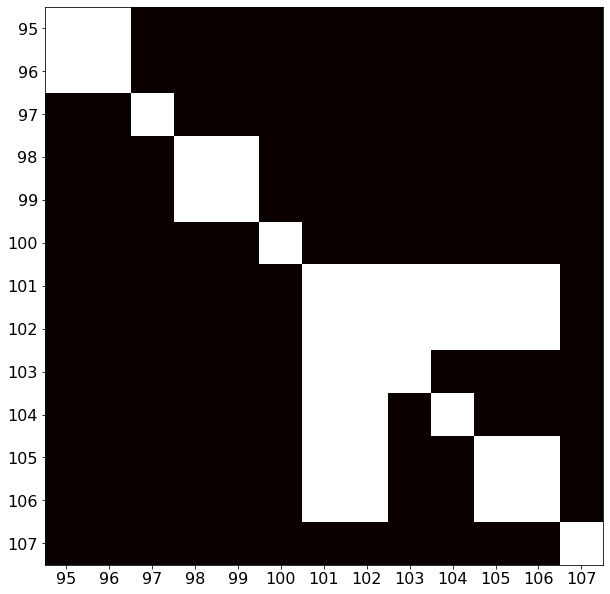

In [136]:
#hide_input

import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(1,1, figsize=(10,11))

img = ax.imshow(overlap_matrix.reshape(ns,ns), cmap='hot', interpolation='nearest')

x_label_list = dh.Record.values

ax.set_xticks(np.arange(0, ns, 1))
ax.set_yticks(np.arange(0, ns, 1))

text = ax.set_xticklabels(x_label_list)
text = ax.set_yticklabels(x_label_list)


Here we see the overlaps: if a pixel is white, it means that the interval on the x-axis and the interval on the y-axis overlap. 


Overlap is symmetric: so each 'child' overlaps with its parent and vice versa. It should become clear that we are actually interested in the "contains" relationship, which is not symmetric and will help us identify parent intervals and child intervals and start reducing the intervals. 

Fortunately this is also supported in Python:

In [137]:
#hide

from sympy import Interval

dh['Interval_obj'] = dh.apply(lambda x: Interval(x['From (m)'], x['To (m)']), axis=1)


cross_interval = itertools.product(dh.Interval_obj,dh.Interval_obj)
contain_matrix = np.array([interval[0].is_proper_superset(interval[1]) for interval in cross_interval])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



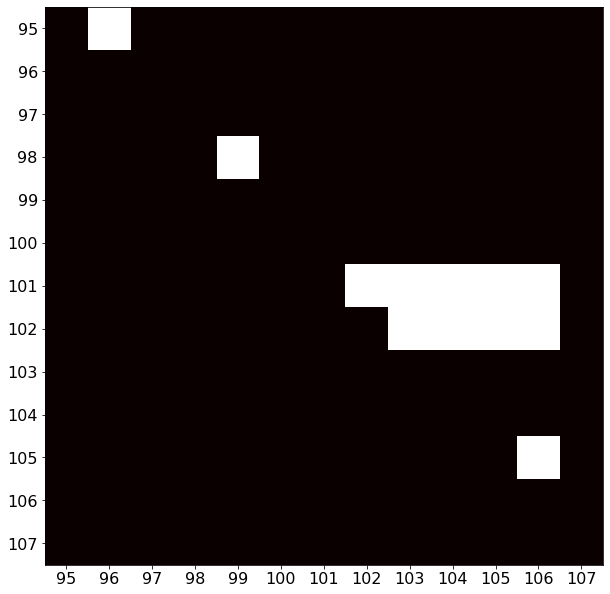

In [138]:
#hide_input

import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(1,1, figsize=(10,11))

img = ax.imshow(contain_matrix.reshape(ns,ns), cmap='hot', interpolation='nearest')

x_label_list = dh.Record.values

ax.set_xticks(np.arange(0, ns, 1))
ax.set_yticks(np.arange(0, ns, 1))

text = ax.set_xticklabels(x_label_list)
text = ax.set_yticklabels(x_label_list)

Now we can pull out a tree 

Of the machine-intelligible formats, a **tree data structure** is clearly the most suited to representing the intervals. 

In [74]:
#hide
from anytree import Node, RenderTree, AsciiStyle, PreOrderIter

interval_pairs = list(itertools.product(dh.Record.values, dh.Record.values))
parent_child = list(contain_matrix)

root = Node("DH")

all_str_to_node = {str(dh['Record'].values[i]) : Node(str(dh['Record'].values[i]), parent = root) for i, column in enumerate(contain_matrix.reshape(ns,ns).T)}

#[all_str_to_node[str(dh_101['Record'].values[i])].parent := root for i, column in enumerate(contain_matrix.reshape(14,14).T) if ~np.any(column)]

contain_matrix_sq = contain_matrix.reshape(ns,ns)

#for i, col in enumerate(contain_matrix_sq.T):
#  print(col)
#  if ~np.any(col):
#    #all_str_to_node[str(dh_101['Record'].values[i])].parent = root
#    print("Root: {}".format(dh_101['Record'].values[i]))
#  else:
#    print("Parent: {}".format(dh_101['Record'].values[::-1][np.argmax(col[::-1])]))
#    print("Child: {}".format(dh_101['Record'].values[i]))



In [75]:
for i, col in enumerate(contain_matrix_sq.T):

  if ~np.any(col):

    all_str_to_node[str(dh['Record'].values[i])].parent = root

  else:

    all_str_to_node[str(dh['Record'].values[i])].parent = all_str_to_node[str(dh['Record'].values[::-1][np.argmax(col[::-1])])]

print(RenderTree(root, style=AsciiStyle()).by_attr())

DH
|-- 95
|   +-- 96
|-- 97
|-- 98
|   +-- 99
|-- 100
|-- 101
|   +-- 102
|       |-- 103
|       |-- 104
|       +-- 105
|           +-- 106
+-- 107


Now we are really getting somewhere- we can actually start looking at the global picture (since we now know which intervals are not "child" intervals)

These are the direct children. We can go ahead and plot them and have a totally accurate picture of the log: 

In [73]:
#hide_input

dh_prime = dh[dh.Record.isin((child.name for child in root.children))]


y_axis = alt.Axis(
    title='Intercept ID',
    offset=5,
    ticks=False,
    domain=False
)


reqd_cols = ['From (m)', 'To (m)', 'Gold (g/t)', 'Width (m)']


alt.Chart(dh_prime[reqd_cols]).mark_bar().encode(
    alt.X('From (m):Q',
        scale=alt.Scale(zero=False)),
    x2='To (m):Q',
    y=alt.Y('Drill Hole:N', axis=y_axis),
    color=alt.Color('Gold (g/t):Q', scale=alt.Scale(scheme="inferno")),
    tooltip=[
        alt.Tooltip('Width (m):Q', title='Width'),
        alt.Tooltip('Gold (g/t):Q', title='Gold Grade')
    ]
).properties(width=800, height=100).configure(background='#D9E9F0')

alt.Chart(...)

In [115]:
dh_prime.dtypes

Drill Hole                 object
Unnamed: 1                 object
From (m)                  float64
To (m)                    float64
Width (m)                 float64
Gold (g/t)                float64
Record                      int64
Interval        interval[float64]
Interval_obj               object
dtype: object

While that is correct, it is not complete: we have left out all of the additional information provided by the smaller sub-intervals! 

In order to incorporate that we will have to remove them from the parent intervals and determine the residual grade (whatever is left once we pull out the gold contained in the subinterval) 

In [35]:
((119) * (3.78) - (3) * (131.5)) / (119 - 3)

0.47689655172413786

As an example of this kind of calculation, a simpler set of intervals from a  Freegold Ventures press release: 

> *Freegold Intercepts 3.78 g/t Au Over 119 Metres Including 131.5 g/t Over 3 Metres Within 573 Metres of 1.21 g/t Au at Golden Summit*

We know the gold grade over the whole 119 meters, and the gold grade over 3 meters, but what is the gold grade over the $119 - 3 = 116 m$?

The solution is a simple weighted average calculation, like compositing over a drillhole: 

$\frac{119 \times 3.78-3 \times 131.5}{119-3} = 0.477 g/t$


Credit to https://twitter.com/BrentCo77759016/status/1326183861722599424 and 


So now we have to do this, but with every single subinterval until we get the residual grade at every point along the drillhole

Fortunately, the tree data structure we selected has specialized methods that make a traversal very simple. 


In [76]:
levelord_nodes = [(node.name, node.children) for node in LevelOrderIter(root)]

levelord_nodes

[('DH',
  (Node('/DH/95'),
   Node('/DH/97'),
   Node('/DH/98'),
   Node('/DH/100'),
   Node('/DH/101'),
   Node('/DH/107'))),
 ('95', (Node('/DH/95/96'),)),
 ('97', ()),
 ('98', (Node('/DH/98/99'),)),
 ('100', ()),
 ('101', (Node('/DH/101/102'),)),
 ('107', ()),
 ('96', ()),
 ('99', ()),
 ('102',
  (Node('/DH/101/102/103'), Node('/DH/101/102/104'), Node('/DH/101/102/105'))),
 ('103', ()),
 ('104', ()),
 ('105', (Node('/DH/101/102/105/106'),)),
 ('106', ())]

In [77]:
nn_np_loi = [(node.name, node.parent) for node in LevelOrderIter(root)]

In [78]:
all_str_to_node

{'100': Node('/DH/100'),
 '101': Node('/DH/101'),
 '102': Node('/DH/101/102'),
 '103': Node('/DH/101/102/103'),
 '104': Node('/DH/101/102/104'),
 '105': Node('/DH/101/102/105'),
 '106': Node('/DH/101/102/105/106'),
 '107': Node('/DH/107'),
 '95': Node('/DH/95'),
 '96': Node('/DH/95/96'),
 '97': Node('/DH/97'),
 '98': Node('/DH/98'),
 '99': Node('/DH/98/99')}

In [79]:
for node, parent in nn_np_loi[::-1][:-1]:
  print(node)
  for child in all_str_to_node[node].children:
    print(child)

106
105
Node('/DH/101/102/105/106')
104
103
102
Node('/DH/101/102/103')
Node('/DH/101/102/104')
Node('/DH/101/102/105')
99
96
107
101
Node('/DH/101/102')
100
98
Node('/DH/98/99')
97
95
Node('/DH/95/96')


In [80]:
dh

,Drill Hole,Unnamed: 1,From (m),To (m),Width (m),Gold (g/t),Record,Interval,Interval_obj
95,BR-022,including,110.0,116.10,6.10,2.62,95,"(110.0, 116.1]","Interval(110.000000000000, 116.100000000000)"
96,BR-022,and including,111.4,113.10,1.70,7.92,96,"(111.4, 113.1]","Interval(111.400000000000, 113.100000000000)"
97,BR-022,and,274.0,299.00,25.00,0.19,97,"(274.0, 299.0]","Interval(274.000000000000, 299.000000000000)"
98,BR-022,and,432.9,439.00,6.10,4.05,98,"(432.9, 439.0]","Interval(432.900000000000, 439.000000000000)"
99,BR-022,including,432.9,435.70,2.80,8.18,99,"(432.9, 435.7]","Interval(432.900000000000, 435.700000000000)"
100,BR-022,and,445.0,452.00,7.00,0.41,100,"(445.0, 452.0]","Interval(445.000000000000, 452.000000000000)"
101,BR-022,and,461.6,512.00,50.40,1.78,101,"(461.6, 512.0]","Interval(461.600000000000, 512.000000000000)"
102,BR-022,including,471.0,512.00,41.00,2.09,102,"(471.0, 512.0]","Interval(471.000000000000, 512.000000000000)"
103,BR-022,and including,471.0,478.00,7.00,2.37,103,"(471.0, 478.0]","Interval(471.000000000000, 478.000000000000)"
104,BR-022,and including,490.0,491.00,1.00,8.15,104,"(490.0, 491.0]","Interval(490.000000000000, 491.000000000000)"


In [81]:
cross_interval = itertools.product(dh.Interval_obj,dh.Interval_obj)

intersect_matrix = np.array([interval[0].intersect(interval[1]) for interval in cross_interval])

intersect_matrix

array([Interval(110.000000000000, 116.100000000000),
       Interval(111.400000000000, 113.100000000000), EmptySet(),
       EmptySet(), EmptySet(), EmptySet(), EmptySet(), EmptySet(),
       EmptySet(), EmptySet(), EmptySet(), EmptySet(), EmptySet(),
       Interval(111.400000000000, 113.100000000000),
       Interval(111.400000000000, 113.100000000000), EmptySet(),
       EmptySet(), EmptySet(), EmptySet(), EmptySet(), EmptySet(),
       EmptySet(), EmptySet(), EmptySet(), EmptySet(), EmptySet(),
       EmptySet(), EmptySet(),
       Interval(274.000000000000, 299.000000000000), EmptySet(),
       EmptySet(), EmptySet(), EmptySet(), EmptySet(), EmptySet(),
       EmptySet(), EmptySet(), EmptySet(), EmptySet(), EmptySet(),
       EmptySet(), EmptySet(),
       Interval(432.900000000000, 439.000000000000),
       Interval(432.900000000000, 435.700000000000), EmptySet(),
       EmptySet(), EmptySet(), EmptySet(), EmptySet(), EmptySet(),
       EmptySet(), EmptySet(), EmptySet(), EmptySe

In [82]:
dh['grade_len'] = dh['Gold (g/t)'] * dh['Width (m)']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [83]:
dh

,Drill Hole,Unnamed: 1,From (m),To (m),Width (m),Gold (g/t),Record,Interval,Interval_obj,grade_len
95,BR-022,including,110.0,116.10,6.10,2.62,95,"(110.0, 116.1]","Interval(110.000000000000, 116.100000000000)",15.982
96,BR-022,and including,111.4,113.10,1.70,7.92,96,"(111.4, 113.1]","Interval(111.400000000000, 113.100000000000)",13.464
97,BR-022,and,274.0,299.00,25.00,0.19,97,"(274.0, 299.0]","Interval(274.000000000000, 299.000000000000)",4.750
98,BR-022,and,432.9,439.00,6.10,4.05,98,"(432.9, 439.0]","Interval(432.900000000000, 439.000000000000)",24.705
99,BR-022,including,432.9,435.70,2.80,8.18,99,"(432.9, 435.7]","Interval(432.900000000000, 435.700000000000)",22.904
100,BR-022,and,445.0,452.00,7.00,0.41,100,"(445.0, 452.0]","Interval(445.000000000000, 452.000000000000)",2.870
101,BR-022,and,461.6,512.00,50.40,1.78,101,"(461.6, 512.0]","Interval(461.600000000000, 512.000000000000)",89.712
102,BR-022,including,471.0,512.00,41.00,2.09,102,"(471.0, 512.0]","Interval(471.000000000000, 512.000000000000)",85.690
103,BR-022,and including,471.0,478.00,7.00,2.37,103,"(471.0, 478.0]","Interval(471.000000000000, 478.000000000000)",16.590
104,BR-022,and including,490.0,491.00,1.00,8.15,104,"(490.0, 491.0]","Interval(490.000000000000, 491.000000000000)",8.150


In [84]:
from sympy import Union
import functools

resid_grades, resid_len = {}, {} 

for node in levelord_nodes[1:]:

  parent_interval = dh[dh['Record'] == float(node[0])]
  child_names = [child.name for child in node[1]]
  child_intervals = [dh[dh['Record'] == float(child)] for child in child_names]

  new_interval_obj = parent_interval.Interval_obj.values[0] - Union([child.Interval_obj.values[0] for child in child_intervals])

  l_child_int = Union([intv['Interval_obj'].values[0] for intv in child_intervals])._measure

  lg_child_int = [dh.loc[int(child_name)]['grade_len'] for child_name in child_names]

  lg_total_int = parent_interval.grade_len.values[0]

  residual_grade = (lg_total_int - sum(lg_child_int)) / (new_interval_obj._measure)

  resid_grades[node[0]] = residual_grade
  resid_len[node[0]] = new_interval_obj

  print("Interval:")
  print(node[0])

  print("Length x Grade:")
  print(lg_total_int - sum(lg_child_int))

  print("Residual Grade:")
  print(residual_grade)


Interval:
95
Length x Grade:
2.517999999999999
Residual Grade:
0.572272727272726
Interval:
97
Length x Grade:
4.75
Residual Grade:
0.190000000000000
Interval:
98
Length x Grade:
1.801000000000002
Residual Grade:
0.545757575757574
Interval:
100
Length x Grade:
2.8699999999999997
Residual Grade:
0.410000000000000
Interval:
101
Length x Grade:
4.022000000000006
Residual Grade:
0.427872340425534
Interval:
107
Length x Grade:
10.4
Residual Grade:
0.520000000000000
Interval:
96
Length x Grade:
13.464
Residual Grade:
7.92000000000005
Interval:
99
Length x Grade:
22.903999999999996
Residual Grade:
8.17999999999997
Interval:
102
Length x Grade:
8.055000000000007
Residual Grade:
0.273514431239389
Interval:
103
Length x Grade:
16.59
Residual Grade:
2.37000000000000
Interval:
104
Length x Grade:
8.15
Residual Grade:
8.15000000000000
Interval:
105
Length x Grade:
2.654999999999994
Residual Grade:
0.870491803278683
Interval:
106
Length x Grade:
50.24
Residual Grade:
100.480000000000


Check these solutions: 95 should be easy to validate

includes 96

95 extends from 110.00 m to 116.10 m (l = 6.10 m)

96 is the interval from 111.40 to 113.10 m (l = 1.70 m)

Larger interval 


(6.10 m)(2.62 g/t) = (1.7 m)(7.92 g/t) + (4.4 m)(x g/t)

Rearranging terms, we get:

$x = \frac{(6.10 m)(2.62 g/t) - (1.7 m)(7.92 g/t)}{ 4.4 m }$

So the residual grade is 0.5723 g/t, which matches the value found above! 

In [45]:
((6.10 * 2.62) - (1.7)*(7.92)) / (4.4)

0.5722727272727269

In [46]:
resid_len

{'100': Interval(445.000000000000, 452.000000000000),
 '101': Interval.Ropen(461.600000000000, 471.000000000000),
 '102': Union(Interval.open(478.000000000000, 490.000000000000), Interval.open(491.000000000000, 505.200000000000), Interval.Lopen(508.750000000000, 512.000000000000)),
 '103': Interval(471.000000000000, 478.000000000000),
 '104': Interval(490.000000000000, 491.000000000000),
 '105': Union(Interval.Ropen(505.200000000000, 506.200000000000), Interval.Lopen(506.700000000000, 508.750000000000)),
 '106': Interval(506.200000000000, 506.700000000000),
 '107': Interval(600.000000000000, 620.000000000000),
 '95': Union(Interval.Ropen(110.000000000000, 111.400000000000), Interval.Lopen(113.100000000000, 116.100000000000)),
 '96': Interval(111.400000000000, 113.100000000000),
 '97': Interval(274.000000000000, 299.000000000000),
 '98': Interval.Lopen(435.700000000000, 439.000000000000),
 '99': Interval(432.900000000000, 435.700000000000)}

In [105]:
Interval(445.000000000000, 452.000000000000).end

452.000000000000

In [47]:
dh['Record'].astype(str).map(resid_len)
dh['Record'].astype(str).map(resid_grades)

95     0.572272727272726
96      7.92000000000005
97     0.190000000000000
98     0.545757575757574
99      8.17999999999997
100    0.410000000000000
101    0.427872340425534
102    0.273514431239389
103     2.37000000000000
104     8.15000000000000
105    0.870491803278683
106     100.480000000000
107    0.520000000000000
Name: Record, dtype: object

TODO: Need to split up the non-contiguous segments so that you can actually plot them 


Idea: use .args attribute
Problem: This is defined for Interval objects as well and it gets us something we don't want

In [48]:
dh['Record'].astype(str).map(resid_len)

95     Union(Interval.Ropen(110.000000000000, 111.400...
96          Interval(111.400000000000, 113.100000000000)
97          Interval(274.000000000000, 299.000000000000)
98     Interval.Lopen(435.700000000000, 439.000000000...
99          Interval(432.900000000000, 435.700000000000)
100         Interval(445.000000000000, 452.000000000000)
101    Interval.Ropen(461.600000000000, 471.000000000...
102    Union(Interval.open(478.000000000000, 490.0000...
103         Interval(471.000000000000, 478.000000000000)
104         Interval(490.000000000000, 491.000000000000)
105    Union(Interval.Ropen(505.200000000000, 506.200...
106         Interval(506.200000000000, 506.700000000000)
107         Interval(600.000000000000, 620.000000000000)
Name: Record, dtype: object

In [91]:


def args_extended(interval):
  if type(interval) == Union:
    return interval.args
  else:
    return interval

remaining_interval_grade = pd.DataFrame({'interval' : dh['Record'].astype(str).map(resid_len), 'grade' : dh['Record'].astype(str).map(resid_grades)})

remaining_interval_grade['split_intervals'] = remaining_interval_grade.interval.apply(args_extended)

rig_exploded = remaining_interval_grade.explode('split_intervals')

In [102]:
rig_exploded

,interval,grade,split_intervals
95,"Union(Interval.Ropen(110.000000000000, 111.400...",0.572272727272726,"Interval.Ropen(110.000000000000, 111.400000000..."
95,"Union(Interval.Ropen(110.000000000000, 111.400...",0.572272727272726,"Interval.Lopen(113.100000000000, 116.100000000..."
96,"Interval(111.400000000000, 113.100000000000)",7.92000000000005,"Interval(111.400000000000, 113.100000000000)"
97,"Interval(274.000000000000, 299.000000000000)",0.190000000000000,"Interval(274.000000000000, 299.000000000000)"
98,"Interval.Lopen(435.700000000000, 439.000000000...",0.545757575757574,"Interval.Lopen(435.700000000000, 439.000000000..."
99,"Interval(432.900000000000, 435.700000000000)",8.17999999999997,"Interval(432.900000000000, 435.700000000000)"
100,"Interval(445.000000000000, 452.000000000000)",0.410000000000000,"Interval(445.000000000000, 452.000000000000)"
101,"Interval.Ropen(461.600000000000, 471.000000000...",0.427872340425534,"Interval.Ropen(461.600000000000, 471.000000000..."
102,"Union(Interval.open(478.000000000000, 490.0000...",0.273514431239389,"Interval.open(478.000000000000, 490.000000000000)"
102,"Union(Interval.open(478.000000000000, 490.0000...",0.273514431239389,"Interval.open(491.000000000000, 505.200000000000)"


In [122]:
rig_exploded['From'] = rig_exploded.split_intervals.apply(lambda x: x.start).astype(float)
rig_exploded['To'] = rig_exploded.split_intervals.apply(lambda x: x.end).astype(float)
rig_exploded['Width'] = (rig_exploded.To - rig_exploded.From).astype(float)

rig_exploded['grade'] = rig_exploded.grade.astype(float)

rig_exploded['drillhole'] = 'BR-022'	

In [123]:
rig_exploded[['From', 'To', 'grade', 'Width']]

,From,To,grade,Width
95,110.00,111.40,0.572273,1.40
95,113.10,116.10,0.572273,3.00
96,111.40,113.10,7.920000,1.70
97,274.00,299.00,0.190000,25.00
98,435.70,439.00,0.545758,3.30
99,432.90,435.70,8.180000,2.80
100,445.00,452.00,0.410000,7.00
101,461.60,471.00,0.427872,9.40
102,478.00,490.00,0.273514,12.00
102,491.00,505.20,0.273514,14.20


In [130]:

y_axis = alt.Axis(
    title='Intercept ID',
    offset=5,
    ticks=False,
    domain=False
)


reqd_cols = ['From', 'To', 'grade', 'Width', 'drillhole']


alt.Chart(rig_exploded[reqd_cols]).mark_bar().encode(
    alt.X('From:Q',
        scale=alt.Scale(zero=False)),
    x2='To:Q',
    y=alt.Y('drillhole:N', axis=y_axis),
    color=alt.Color('grade:Q', scale=alt.Scale(scheme="inferno")),
    tooltip=[
        alt.Tooltip('Width:Q', title='Width'),
        alt.Tooltip('grade:Q', title='Gold Grade')
    ]
).properties(width=800, height=100).configure(background='#D9E9F0').interactive()

alt.Chart(...)